Installing Dependencies


In [19]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from itertools import combinations
from collections import Counter
import seaborn as sns
import yfinance as yfin
import math
import pandas_ta as ta
from datetime import date
import time
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = "{:,.6f}".format

Loading the pre processed data

In [20]:
df_normalized = pd.read_csv("/content/data.csv") # Change the file path name as required
df_normalized.set_index("Date", inplace=True)

Identifying the features and the target of our analysis

target: Gamma (Class Identifier)

features: All other columns (since Date is already index)

In [21]:
features = df_normalized.drop(columns=["Gamma"])
target = df_normalized["Gamma"]

Calculating the Mean Absolute Deviation for feature-selection

`MAD = sum(feature(i) - mean(feature)) / N`

Lower MAD: Feature is consistent throughout all observations (less important)

Higher MAD: Feature fluctuates throughout the dataset (more important)

To identify more important features, the MAD is sorted in descending order



In [22]:
mean_features = features.mean()
mad_features = np.sum(np.abs(features - mean_features), axis=0) / len(features)
mad_features.sort_values(ascending=False)

,0
AOBV_LR_2,0.499995
AOBV_SR_2,0.499995
DEC_1,0.499983
INC_1,0.499902
AMATe_LR_8_21_2,0.499788
...,...
DMN_14,0.049333
LOGRET_1,0.048771
EFI_13,0.028841
BEARP_13,0.026094


Calculating the Pearson Correlation for feature-selection - Captures Linear Dependencies only

`Correlation = sum(x(i)y(i) - mean(x)mean(y)) / (N-1)sigma(x)sigma(y)`

Lower Absolute Correlation: Feature is less correlated with the target (less important)

Higher Absolute Correlation: Feature is more correlated with the target (more important)

To identify more important features, the correlation coefficient is sorted in descending order



In [23]:
correlations = df_normalized.corr()['Gamma'].drop('Gamma')
np.abs(correlations).sort_values(ascending=False)

,Gamma
BBP_5_2.0,0.503438
CCI_14_0.015,0.418764
CFO_9,0.394500
BULLP_13,0.385657
J_9_3,0.378257
...,...
Volume,0.001269
DCM_20_20,0.001225
KCLe_20_2,0.001162
DCL_20_20,0.000548


Performing Principal Feature Analysis for feature selection

The first step is to identify how many principal components explain majority of the data

Using a Scree Plot for visual identification



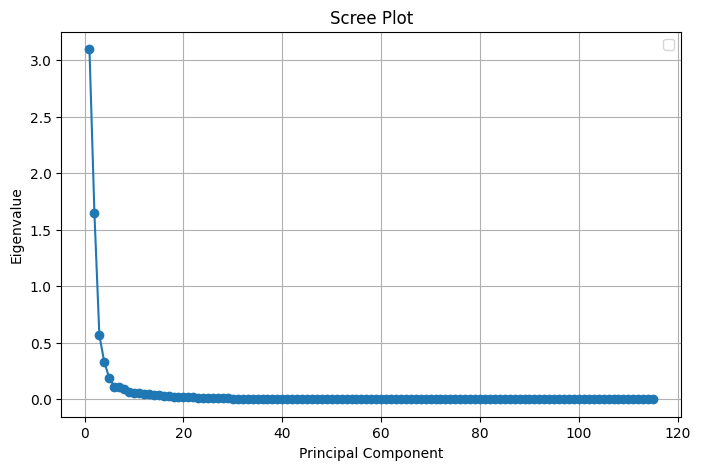

In [24]:
pca_full = PCA()
pca_full.fit(features)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_full.explained_variance_) + 1),
         pca_full.explained_variance_,
         marker='o', linestyle='-')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.show()

Identifying from Scree Plot that the optimal number of components is 5

Using 5 principal components, we perform principal feature selection

First we fit the PCA with the optimal number of components

Then we calculate the factor loadings - How much each feature contributes to each principal component

Then we compute the L2 (Euclidean) norm of each feature to identify the importance of the feature across all components

A higher norm value indicates a more important feature

A lower norm value indicates a less important feature

Hence, we sort the features in descending order of their importance



In [25]:
def principal_feature(X, explained_components=5):
    pca = PCA(n_components=explained_components)
    pca.fit(X)

    loadings = np.abs(pca.components_.T)
    feature_scores = np.linalg.norm(loadings, axis=1)

    feature_ranking = pd.Series(feature_scores, index=X.columns)
    top_features = feature_ranking.sort_values(ascending=False)

    return top_features

pfa = principal_feature(features, 5)

Performing a Tree-based Feature Selection - Captures Non-Linear Dependencies efficiently

Utilising ExtraTreesClassifier for fitting randomized Decision Trees

It is an effective method since it prevents overfitting by injecting randomness in classification

We select 100 random trees for classification. ExtraTreesClassifier randomly chooses the subsamples and cutoff points

We extract feature importances for feature selection

A higher feature importance indicates a more important feature

Hence we sort the features in a descending order of importance

Since the classifier is used for feature selection, the data is not split into train and test sets



In [26]:
X = features
y = target

model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.set_index("Feature", inplace=True)


Selecting the 1st Quartile of the salient features for each statistic



In [27]:
top_n = int(0.25 * len(mad_features))
q1_mad = set(mad_features.iloc[:top_n].index)

top_n1 = int(0.25 * len(correlations))
q1_cor = set(correlations.iloc[:top_n1].index)

top_n2 = int(0.25 * len(pfa))
q1_pfa = set(pfa.iloc[:top_n2].index)

top_n3 = int(0.25 * len(feature_importance_df))
q1_rf = set(feature_importance_df.iloc[:top_n3].index)

Now we have 4 sets of salient features

We want to select the features that appear in atleast (n) sets

In [28]:
sets = [q1_mad, q1_cor, q1_pfa, q1_rf]

all_features = []
for s in sets:
    all_features.extend(s)

feature_counts = Counter(all_features)

at_least_1 = [f for f, count in feature_counts.items() if count >= 1]
at_least_2 = [f for f, count in feature_counts.items() if count >= 2]
at_least_3 = [f for f, count in feature_counts.items() if count >= 3]
at_least_4 = [f for f, count in feature_counts.items() if count == 4]

print("Features in at least 1 set:", len(at_least_1))
print("Features in at least 2 sets:", len(at_least_2))
print("Features in at least 3 sets:", len(at_least_3))
print("Features in all 4 sets:", len(at_least_4))



Features in at least 1 set: 62
Features in at least 2 sets: 44
Features in at least 3 sets: 3
Features in all 4 sets: 3


Performing MLP Classification with the K=10 Fold Cross Validation

The data is not sorted, hence the shuffle is turned off

The cross_val_score gives us the accuracy of prediction in the test set

The mean of the accuracy is recorded



In [15]:
sets = []
feat = []
acc = []
times = []

features_list = [
    ("at_least_4", features[at_least_4]),
    ("at_least_3", features[at_least_3]),
    ("at_least_2", features[at_least_2]),
    ("at_least_1", features[at_least_1]),
    ("q1_mad", features[list(set(q1_mad))]),
    ("q1_cor", features[list(set(q1_cor))]),
    ("q1_pfa", features[list(set(q1_pfa))]),
    ("q1_rf", features[list(set(q1_rf))]),
    ("all_features", features)
]

no_of_features_list = [3, 3, 44, 62, 28, 28, 28, 28, 115]

for idx, (name, feature) in enumerate(features_list):
    X = feature
    y = target

    start_time = time.time()

    np.random.seed(42)

    hidden_layer_sizes = int((X.shape[1] + len(np.unique(y))) / 2)
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='logistic',
        solver='lbfgs',
        batch_size='auto',
        learning_rate='adaptive',
        learning_rate_init=0.03,
        max_iter=5000,
        momentum=0.2,
        random_state=np.random.get_state()[1][0],
        early_stopping=False
    )
    cv_generator = StratifiedKFold(n_splits=10, shuffle=False)
    scores = cross_val_score(mlp, X, y, cv=cv_generator)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Cross-validated Accuracy for features in {name} sets: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"in {execution_time:.2f} seconds")

    sets.append(name)
    feat.append(no_of_features_list[idx])
    acc.append(scores.mean())
    times.append(execution_time)

    print(f"Appended to final_df")

final_df = pd.DataFrame({
    "Sets": sets,
    "No. of Features": feat,
    "Accuracy(in decimals)": acc,
    "Time(in seconds)": times
})

final_df


Cross-validated Accuracy for features in at_least_4 sets: 0.6810 ± 0.0310
in 0.29 seconds
Appended to final_df
Cross-validated Accuracy for features in at_least_3 sets: 0.6810 ± 0.0310
in 0.24 seconds
Appended to final_df
Cross-validated Accuracy for features in at_least_2 sets: 0.6958 ± 0.0250
in 156.03 seconds
Appended to final_df
Cross-validated Accuracy for features in at_least_1 sets: 0.7284 ± 0.0379
in 61.80 seconds
Appended to final_df
Cross-validated Accuracy for features in q1_mad sets: 0.6888 ± 0.0403
in 213.60 seconds
Appended to final_df
Cross-validated Accuracy for features in q1_cor sets: 0.6888 ± 0.0403
in 178.52 seconds
Appended to final_df
Cross-validated Accuracy for features in q1_pfa sets: 0.7313 ± 0.0148
in 82.56 seconds
Appended to final_df
Cross-validated Accuracy for features in q1_rf sets: 0.7675 ± 0.0354
in 147.98 seconds
Appended to final_df
Cross-validated Accuracy for features in all_features sets: 0.7279 ± 0.0261
in 250.37 seconds
Appended to final_df


,Sets,No. of Features,Accuracy(in decimals),Time(in seconds)
0,at_least_4,3,0.680990,0.291978
1,at_least_3,3,0.680990,0.235835
2,at_least_2,44,0.695818,156.031929
3,at_least_1,62,0.728390,61.796300
4,q1_mad,28,0.688797,213.598737
5,q1_cor,28,0.688797,178.519851
6,q1_pfa,28,0.731252,82.555748
7,q1_rf,28,0.767522,147.976972
8,all_features,115,0.727948,250.372454


As we can see from above that the features identified by the statistics - PFA ExtraTrees Classifier provide a better accuracy in the model than including all the features, and that too in a short amount of time. This means, that this model, improves performance by a better feature selection.

Similarly, the features identified by the MAD and COR perform slightly worse than the model with all features, probably because their simplicity in feature selection. Pearsons correlation only identifies the linear relation between the target and the features, and fails to capture the non-linear dependencies. Hence its performance is slightly worse than the other models. Similarly for MAD, it is a statistic of only order 1, hence the complex relationship is not fully captured as by the ExtraTrees Classifier or by Principal Feature Analysis.

The features that appear atleast in one of the sets are the most important features and provides a better accuracy than including all the features in a much shorter time.

We reproduce the findings of the paper, by showing a better method of feature selection, thus reducing computational power and time to better predict stock price movements on technical indicators.

Features identified by the tree based classifier capture the best complexity in the data and hence, with only 28 features, it gives the best accuracy with a much shorter model training and testing time.

The features in atleast 4 or 3 sets, reduce the number of features significantly, hence the accuracy in their model is less than the one with all features, however they provide almost 68% accuracy which shows that those features are indeed the most important ones affecting the stock prices.

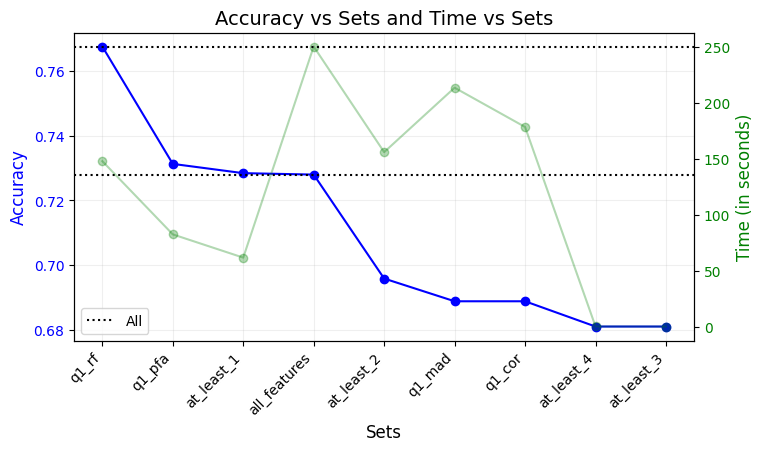

In [18]:
df_sorted = final_df.sort_values(by="Accuracy(in decimals)", ascending=False)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(df_sorted["Sets"], df_sorted["Accuracy(in decimals)"], marker='o', linestyle='-', color='b')
ax1.set_xlabel('Sets', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(y=final_df.loc[final_df["Sets"] == "all_features", "Accuracy(in decimals)"].values[0], color='black', linestyle=':', label='All')
ax1.set_xticks(df_sorted["Sets"])
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(df_sorted["Sets"], df_sorted["Time(in seconds)"], marker='o', linestyle='-', color='g', alpha = 0.3)
ax2.axhline(y=final_df.loc[final_df["Sets"] == "all_features", "Time(in seconds)"].values[0], color='black', linestyle=':', label='All')
ax2.set_ylabel('Time (in seconds)', fontsize=12, color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Accuracy vs Sets and Time vs Sets', fontsize=14)

ax1.grid(True, alpha = 0.2)
ax2.grid(False)

plt.legend()
plt.show()


As we can see from the above figure that the sets to the left of "all_features" provide a better accuracy in a lower time frame by using lesser, more important features.